In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# Is given date holiday or not
import holidays
# Cacluate haversine distance
from haversine import haversine

from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
import xgboost as xgb

In [2]:
# All pandas configurations
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
# fix seed
SEED = 123
np.random.seed(SEED)

In [4]:
# Constant used later in this notebook
CITY_LNG_BORDER = (-74.03, -73.75)
CITY_LAT_BORDER = (40.63, 40.85)
DAY_OF_WEEK = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')
MONTH = ('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December')

In [5]:
# Parse datetime here == pd.datetime(train/test.pickup_datetime)
train = pd.read_csv('data/train.csv', parse_dates=['pickup_datetime'])
test = pd.read_csv('data/test.csv', parse_dates=['pickup_datetime'])

In [6]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [7]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988,40.732,-73.990,40.757,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964,40.680,-73.960,40.655,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997,40.738,-73.986,40.730,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956,40.772,-73.986,40.730,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970,40.761,-73.962,40.756,N


The test set doesn't contain pickoff_datetime and trip duration.

In [8]:
train.drop('id', axis=1).describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [9]:
test.drop('id', axis=1).describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,625134.000,625134.000,625134.000,625134.000,625134.000,625134.000
mean,1.535,1.662,-73.974,40.751,-73.973,40.752
std,0.499,1.311,0.073,0.030,0.073,0.036
min,1.000,0.000,-121.933,37.390,-121.933,36.601
25%,1.000,1.000,-73.992,40.737,-73.991,40.736
50%,2.000,1.000,-73.982,40.754,-73.980,40.755
75%,2.000,2.000,-73.967,40.768,-73.963,40.770
max,2.000,9.000,-69.249,42.815,-67.497,48.858


In [10]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [11]:
test.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

Great! No null or missing values in both datasets. Let's check duplicate values though.

In [12]:
train.shape == train.drop_duplicates().shape

True

In [13]:
test.shape == test.drop_duplicates().shape

True

No duplicate values in these datasets. Kaggle has already done some clean up for us.

In [14]:
# Convert store_and_fwd_flag to numerical values
train['store_and_fwd_flag'] = train.store_and_fwd_flag.map({'Y':1, 'N':0})
test['store_and_fwd_flag'] = test.store_and_fwd_flag.map({'Y':1, 'N':0})

In [15]:
train.passenger_count.value_counts(sort=False)

0         60
1    1033540
2     210318
3      59896
4      28404
5      78088
6      48333
7          3
8          1
9          1
Name: passenger_count, dtype: int64

In [16]:
test.passenger_count.value_counts(sort=False)

0        23
1    443447
2     90027
3     25686
4     12017
5     33411
6     20521
9         2
Name: passenger_count, dtype: int64

It looks like train set has passengers values '7' and '8' which are not in test set. We must remove that in train set because lately we are going to use technique called one hot encoding and both dataset must have the same values.

In [17]:
# Remove passenger 7 and 8 and verify the results
train = train[(train.passenger_count != 7) & (train.passenger_count !=8)]
train.passenger_count.value_counts(sort=False)

0         60
1    1033540
2     210318
3      59896
4      28404
5      78088
6      48333
9          1
Name: passenger_count, dtype: int64

## Plot distribution of the dataset
Before proceeding, we have to visualize both train and test set because if both train and test have huge difference in distribution, the results of our machine learning models would be poor and might lead to a very bad performance in real world.

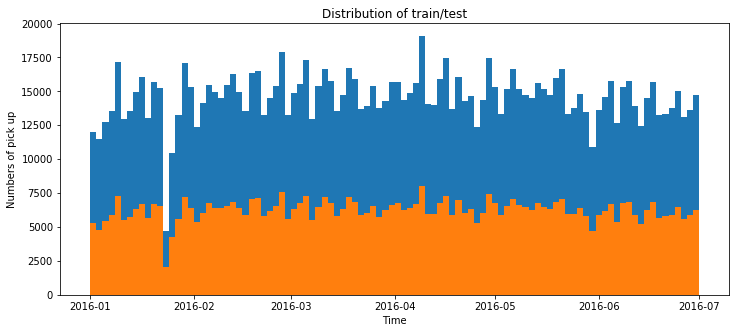

In [18]:
plt.figure(figsize=(12, 5))

plt.hist(train.pickup_datetime, bins=100, label='train')
plt.hist(test.pickup_datetime, bins=100, label='test')
plt.title('Distribution of train/test')
plt.xlabel('Time')
plt.ylabel('Numbers of pick up')
plt.show()

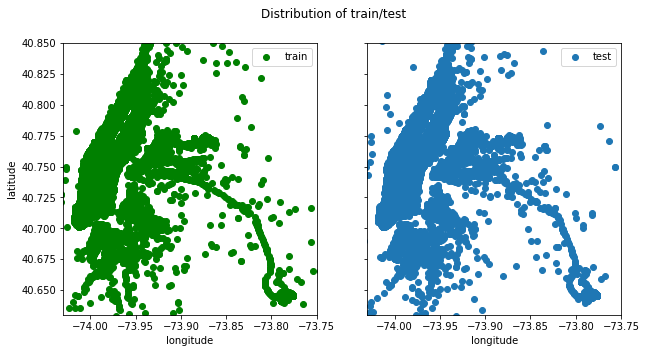

In [19]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10,5))
ax[0].scatter(train['pickup_longitude'].values[:100000], train['pickup_latitude'].values[:100000], label='train', c='green')
ax[1].scatter(test['pickup_longitude'].values[:100000], test['pickup_latitude'].values[:100000], label='test')
fig.suptitle('Distribution of train/test')

ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[0].legend(loc=0)
ax[1].legend(loc=0)

plt.ylim(CITY_LAT_BORDER)
plt.xlim(CITY_LNG_BORDER)

plt.show()

Both train and test set have the same distribution

## Extracting date and weather features
We are going to extract valuable information from datetime. Feature engineering plays a big role in machine learning and we will spend a lot time here - garbage in garbage out. 

In [20]:
us_holidays = holidays.UnitedStates()

train['month'] = train.pickup_datetime.dt.month
train['day_of_week'] = train.pickup_datetime.dt.weekday
train['hour'] = train.pickup_datetime.dt.hour
train['day'] = train.pickup_datetime.dt.day
train['is_holiday'] = train.pickup_datetime.apply(lambda x: x in us_holidays)

test['month'] = test.pickup_datetime.dt.month
test['day_of_week'] = test.pickup_datetime.dt.weekday
test['hour'] = test.pickup_datetime.dt.hour
test['day'] = test.pickup_datetime.dt.day
test['is_holiday'] = test.pickup_datetime.apply(lambda x: x in us_holidays)

We will use external data derived from https://www.kaggle.com/cabaki/knycmetars2016 and merge together with our train and test set in order to adding more information of weather status based on datetime

In [21]:
weather = pd.read_csv('data/KNYC_Metars.csv', parse_dates=['Time'])
weather['year'] = weather['Time'].dt.year
weather['month'] = weather['Time'].dt.month
weather['day'] = weather['Time'].dt.day
weather['hour'] = weather['Time'].dt.hour
weather = weather[weather.year == 2016][['month', 'day', 'hour', 'Conditions']]

train = pd.merge(train, weather, on=['month', 'day', 'hour'], how='left')
test = pd.merge(test, weather, on=['month', 'day', 'hour'], how='left')

In [22]:
# Verify our results on train set
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,day_of_week,hour,day,is_holiday,Conditions
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,455,3,0,17,14,False,Overcast
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,663,6,6,0,12,False,Unknown
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,2124,1,1,11,19,False,Clear
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,0,429,4,2,19,6,False,Clear
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,0,435,3,5,13,26,False,Clear


In [23]:
# Verify our results on test set
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,month,day_of_week,hour,day,is_holiday,Conditions
0,id3004672,1,2016-06-30 23:59:58,1,-73.988,40.732,-73.990,40.757,0,6,3,23,30,False,Clear
1,id3505355,1,2016-06-30 23:59:53,1,-73.964,40.680,-73.960,40.655,0,6,3,23,30,False,Clear
2,id1217141,1,2016-06-30 23:59:47,1,-73.997,40.738,-73.986,40.730,0,6,3,23,30,False,Clear
3,id2150126,2,2016-06-30 23:59:41,1,-73.956,40.772,-73.986,40.730,0,6,3,23,30,False,Clear
4,id1598245,1,2016-06-30 23:59:33,1,-73.970,40.761,-73.962,40.756,0,6,3,23,30,False,Clear


## Exploratory data analysis

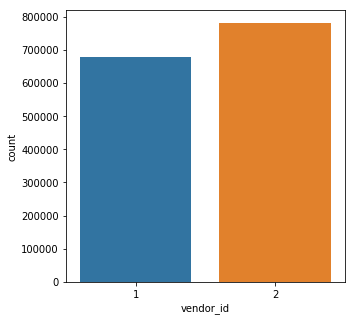

In [24]:
plt.figure(figsize=(5,5))

sns.countplot(data=train, x='vendor_id')
plt.show()

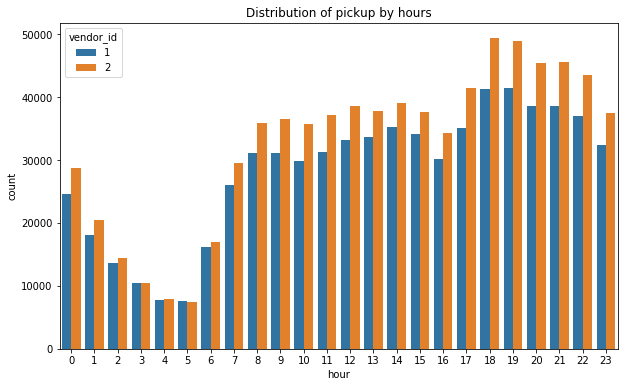

In [25]:
plt.figure(figsize=(10,6))

sns.countplot(data=train, x='hour', hue='vendor_id')
plt.title('Distribution of pickup by hours')

plt.show()

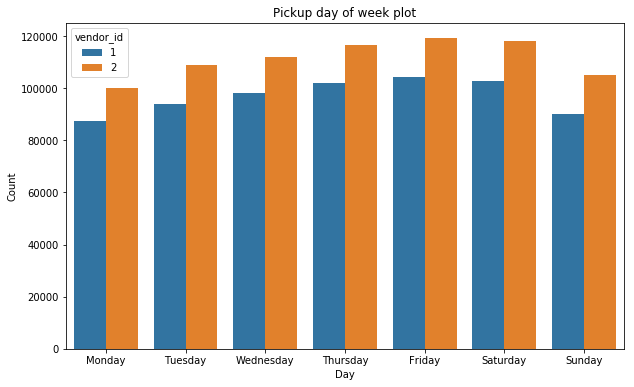

In [26]:
plt.figure(figsize=(10,6))

sns.countplot(data=train, x='day_of_week', hue='vendor_id')
plt.title('Pickup day of week plot')
plt.xlabel('Day')
plt.xticks(range(0,7), DAY_OF_WEEK[:7])
plt.ylabel('Count')
plt.show()

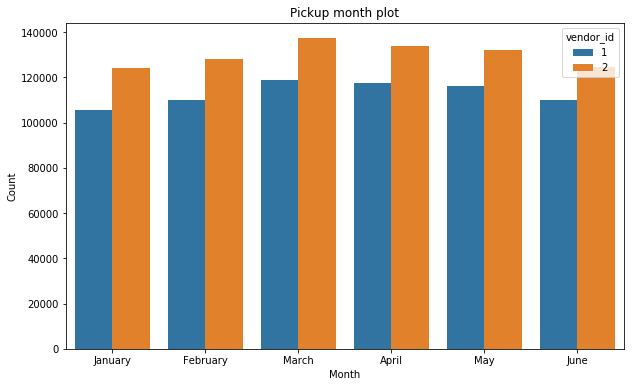

In [27]:
plt.figure(figsize=(10,6))

sns.countplot(data=train, x='month', hue='vendor_id')
plt.title('Pickup month plot')
plt.xlabel('Month')
plt.xticks(range(0,6), MONTH[:6])
plt.ylabel('Count')
plt.show()

## Clustering
We are going to extract valuable information by grouping them into neighborhoods. This will help our model learn much more easily by using unsupervised learning technique called Kmeans

In [28]:
# Concat latitude and longitude together
lat_lng = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

In [29]:
# Kmeans
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(lat_lng)

train['pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train['dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])

# Use train to predict test in order to prevent data leakage and simulate the real world situation
test['pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test['dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

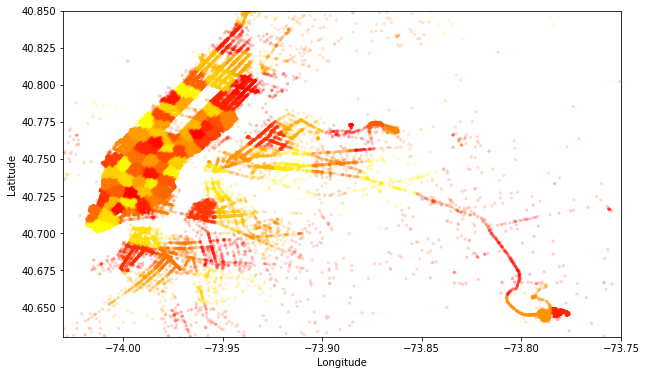

In [30]:
# Visualize our results
plt.figure(figsize=(10,6))

plt.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], s=10, lw=0,
           c=train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
plt.xlim(CITY_LNG_BORDER)
plt.ylim(CITY_LAT_BORDER)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

## Calculating the distance 
Another interesting idea we can do with latitude and longitude is to calculate the distance between 2 points.

In [31]:
def calculate_haversine(x):
    a = (x.pickup_latitude, x.pickup_longitude)
    b = (x.dropoff_latitude, x.dropoff_longitude)
    
    return haversine(a, b)


def calculate_manhattan(x):
    
    return np.abs(x.pickup_latitude - x.dropoff_latitude) + np.abs(x.pickup_longitude - x.dropoff_longitude)

def calculate_euclidean(x):
    
    return np.sqrt(np.square(x.pickup_latitude - x.dropoff_latitude) + np.square(x.pickup_longitude - x.dropoff_longitude))

    
train['haversine_distance'] = train.apply(calculate_haversine, axis=1)
train['manhattan_distance'] = train.apply(calculate_manhattan, axis=1)
train['euclidean_distance'] = train.apply(calculate_euclidean, axis=1)

test['haversine_distance'] = test.apply(calculate_haversine, axis=1)
test['manhattan_distance'] = test.apply(calculate_manhattan, axis=1)
test['euclidean_distance'] = test.apply(calculate_euclidean, axis=1)

## Trip duration

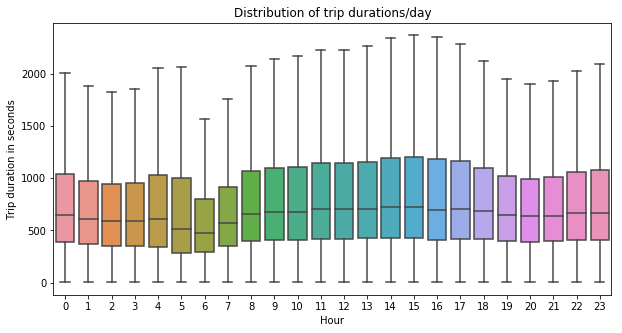

In [32]:
# Plot trip duration distribution based on time of day
plt.figure(figsize=(10, 5))
sns.boxplot(train.hour, train.trip_duration, showfliers=False)
plt.title('Distribution of trip durations/day')
plt.ylabel('Trip duration in seconds')
plt.xlabel('Hour')
plt.show()

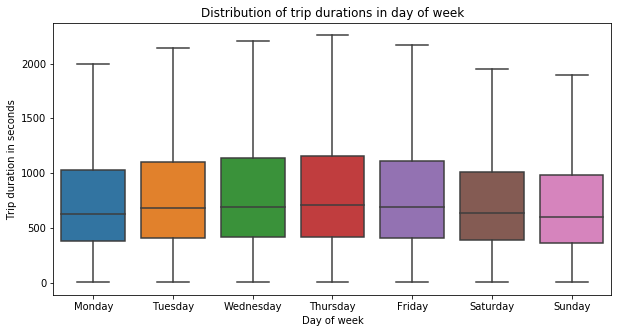

In [33]:
# Plot trip duration distribution based on day of week
plt.figure(figsize=(10, 5))
sns.boxplot(train.day_of_week, train.trip_duration, showfliers=False)
plt.title('Distribution of trip durations in day of week')
plt.ylabel('Trip duration in seconds')
plt.xlabel('Day of week')
plt.xticks(range(0,7), DAY_OF_WEEK[:7])

plt.show()

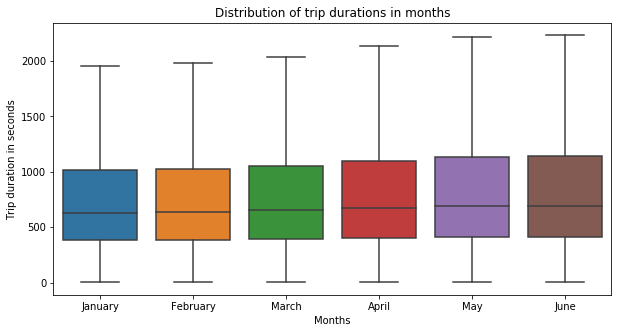

In [34]:
# Plot trip duration distribution based on time of day
plt.figure(figsize=(10, 5))
sns.boxplot(train.month, train.trip_duration, showfliers=False)
plt.title('Distribution of trip durations in months')
plt.ylabel('Trip duration in seconds')
plt.xlabel('Months')
plt.xticks(range(0,6), MONTH[:6])

plt.show()

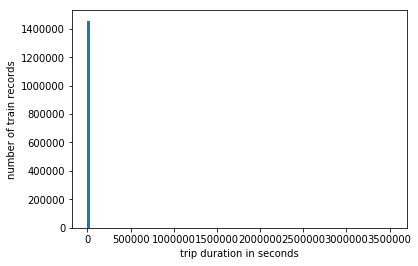

In [35]:
plt.hist(train.trip_duration, bins=100)
plt.xlabel('trip duration in seconds')
plt.ylabel('number of train records')
plt.show()

There are outliers but since the metrics is root mean square log error, I will not remove them from the dataset but instead perform log transformation. 

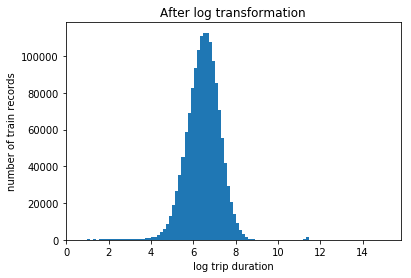

In [36]:
train['log_trip_duration'] = np.log1p(train.trip_duration.values)
plt.hist(train.log_trip_duration, bins=100)
plt.title('After log transformation')
plt.xlabel('log trip duration')
plt.ylabel('number of train records')
plt.show()

## Get dummies/ one hot encoding
Many models cannot deal directly with categorical features for example they might see passenger_count 6 is closer and more relevant to 5 or 7 than other numbers. Thus, one hot encoding has been implemented here. Even though xgboost could handle categorical features well, Linear regression couldn’t.

In [37]:
dummies = ['vendor_id', 
           'passenger_count', 
           'store_and_fwd_flag', 
           'month', 
           'day_of_week', 
           'hour', 
           'is_holiday', 
           'Conditions', 
           'pickup_cluster', 
           'dropoff_cluster']


train = pd.get_dummies(train,columns=dummies)
train.drop(['id', 
            'pickup_datetime',
            'dropoff_datetime',
            'trip_duration', 
            'day'], inplace=True, axis=1)

test = pd.get_dummies(test,columns=dummies)
test.drop(['id', 
            'pickup_datetime', 
            'day'], inplace=True, axis=1)

In [38]:
# Check the length and features names of both train and test set
train.drop('log_trip_duration', axis=1).columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [39]:
# Create analytical_base_table for other notebooks
train.to_csv('data/train_abt.csv', index=None)
test.to_csv('data/test_abt.csv', index=None)

## Train xgboost with the best hyperparameter from Bayesian Optimization


In [40]:
X = train.drop('log_trip_duration', axis=1)
y = train.log_trip_duration

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_test = test

# Create dataframe for storing the test set prediction
sub = pd.DataFrame()
sub['id'] = pd.read_csv('data/test.csv').id
sub['trip_duration'] = np.zeros(X_test.shape[0])

params = {}
params['objective'] = 'reg:linear'  
params['eval_metric'] = 'rmse'      
params['silent'] = 1                
params['tree_method'] = 'hist'
params['eta'] = 0.1         
params['max_depth'] = 12
params['colsample_bytree'] = 0.934230
params['subsample'] = 0.998524
params['min_child_weight'] = 18
params['gamma'] = 0.068413
params['alpha'] = 8.641812
params['seed'] = SEED

# Convert data to XGBoost data format 
d_train = xgb.DMatrix(X_train, y_train)
d_valid = xgb.DMatrix(X_valid, y_valid)
d_test = xgb.DMatrix(X_test)

# Monitor overfitting
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
reg = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=50)  

# Predict valid set for plot
pred_valid = reg.predict(d_valid, ntree_limit=reg.best_ntree_limit)

# Predict test set
sub['trip_duration'] += reg.predict(d_test, ntree_limit=reg.best_ntree_limit)

# Convert log transformation back to original values
sub['trip_duration'] = np.expm1(sub.trip_duration)

# Save the test prediction to csv format
sub.to_csv('sub/model_optim_sub.csv', index=False)

[00:52:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[0]	train-rmse:5.42203	valid-rmse:5.42184
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[1]	train-rmse:4.8844	valid-rmse:4.88427
[2]	train-rmse:4.40102	valid-rmse:4.40092
[3]	train-rmse:3.96644	valid-rmse:3.96641
[4]	train-rmse:3.57586	valid-rmse:3.57594
[5]	train-rmse:3.22496	valid-rmse:3.22509
[6]	train-rmse:2.90972	valid-rmse:2.90993
[7]	train-rmse:2.62679	valid-rmse:2.62709
[8]	train-rmse:2.3729	valid-rmse:2.3733
[9]	train-rmse:2.14523	valid-rmse:2.14574
[10]	train-rmse:1.94124	valid-rmse:1.94185
[11]	train-rmse:1.75856	valid-rmse:1.75929
[12]	train-rmse:1.5953	valid-rmse:1.59617
[13]	train-rmse:1.4495	valid-rmse:1.45049
[14]	train-rmse:1.31955	valid-rmse:1.32067
[15]	train-rmse:1.20392	valid-rmse:1.20521
[16]	train-rmse:1.10127	valid-rmse:1.1027
[17]	train-rmse:1.0102	valid-rmse:1.01179


[177]	train-rmse:0.384758	valid-rmse:0.403411
[178]	train-rmse:0.384578	valid-rmse:0.403285
[179]	train-rmse:0.384488	valid-rmse:0.40324
[180]	train-rmse:0.384267	valid-rmse:0.40314
[181]	train-rmse:0.384114	valid-rmse:0.403049
[182]	train-rmse:0.38384	valid-rmse:0.402904
[183]	train-rmse:0.383778	valid-rmse:0.402881
[184]	train-rmse:0.383724	valid-rmse:0.402853
[185]	train-rmse:0.383579	valid-rmse:0.402764
[186]	train-rmse:0.383411	valid-rmse:0.402671
[187]	train-rmse:0.383297	valid-rmse:0.402612
[188]	train-rmse:0.383216	valid-rmse:0.402572
[189]	train-rmse:0.383134	valid-rmse:0.402529
[190]	train-rmse:0.383011	valid-rmse:0.40246
[191]	train-rmse:0.3829	valid-rmse:0.402407
[192]	train-rmse:0.382811	valid-rmse:0.402355
[193]	train-rmse:0.382677	valid-rmse:0.402273
[194]	train-rmse:0.382595	valid-rmse:0.402243
[195]	train-rmse:0.382492	valid-rmse:0.402208
[196]	train-rmse:0.382329	valid-rmse:0.402164
[197]	train-rmse:0.38225	valid-rmse:0.402118
[198]	train-rmse:0.382163	valid-rmse:0.40

[357]	train-rmse:0.365892	valid-rmse:0.395067
[358]	train-rmse:0.365807	valid-rmse:0.395026
[359]	train-rmse:0.365699	valid-rmse:0.394981
[360]	train-rmse:0.36567	valid-rmse:0.394968
[361]	train-rmse:0.365639	valid-rmse:0.394954
[362]	train-rmse:0.365595	valid-rmse:0.394937
[363]	train-rmse:0.365526	valid-rmse:0.394935
[364]	train-rmse:0.365462	valid-rmse:0.394918
[365]	train-rmse:0.365363	valid-rmse:0.39489
[366]	train-rmse:0.365311	valid-rmse:0.394864
[367]	train-rmse:0.365276	valid-rmse:0.394866
[368]	train-rmse:0.365194	valid-rmse:0.394859
[369]	train-rmse:0.365144	valid-rmse:0.394849
[370]	train-rmse:0.365077	valid-rmse:0.394826
[371]	train-rmse:0.364966	valid-rmse:0.394775
[372]	train-rmse:0.364915	valid-rmse:0.394766
[373]	train-rmse:0.364792	valid-rmse:0.394704
[374]	train-rmse:0.364664	valid-rmse:0.394638
[375]	train-rmse:0.364534	valid-rmse:0.394584
[376]	train-rmse:0.364461	valid-rmse:0.39457
[377]	train-rmse:0.364389	valid-rmse:0.394561
[378]	train-rmse:0.364306	valid-rmse:

[536]	train-rmse:0.353433	valid-rmse:0.391481
[537]	train-rmse:0.35335	valid-rmse:0.391452
[538]	train-rmse:0.353314	valid-rmse:0.391447
[539]	train-rmse:0.353247	valid-rmse:0.391431
[540]	train-rmse:0.353148	valid-rmse:0.391412
[541]	train-rmse:0.353087	valid-rmse:0.391392
[542]	train-rmse:0.353018	valid-rmse:0.391356
[543]	train-rmse:0.352967	valid-rmse:0.391342
[544]	train-rmse:0.352941	valid-rmse:0.391334
[545]	train-rmse:0.352907	valid-rmse:0.391325
[546]	train-rmse:0.352892	valid-rmse:0.39132
[547]	train-rmse:0.352844	valid-rmse:0.391312
[548]	train-rmse:0.352797	valid-rmse:0.391303
[549]	train-rmse:0.352755	valid-rmse:0.391298
[550]	train-rmse:0.352722	valid-rmse:0.391291
[551]	train-rmse:0.352619	valid-rmse:0.39128
[552]	train-rmse:0.352583	valid-rmse:0.391257
[553]	train-rmse:0.352541	valid-rmse:0.391242
[554]	train-rmse:0.35251	valid-rmse:0.391237
[555]	train-rmse:0.352455	valid-rmse:0.391221
[556]	train-rmse:0.352428	valid-rmse:0.391215
[557]	train-rmse:0.352363	valid-rmse:0

[715]	train-rmse:0.343302	valid-rmse:0.390131
[716]	train-rmse:0.343282	valid-rmse:0.390132
[717]	train-rmse:0.343257	valid-rmse:0.390128
[718]	train-rmse:0.343218	valid-rmse:0.390125
[719]	train-rmse:0.343153	valid-rmse:0.390128
[720]	train-rmse:0.343103	valid-rmse:0.390121
[721]	train-rmse:0.343078	valid-rmse:0.390119
[722]	train-rmse:0.343049	valid-rmse:0.390114
[723]	train-rmse:0.343005	valid-rmse:0.390104
[724]	train-rmse:0.342937	valid-rmse:0.390105
[725]	train-rmse:0.342859	valid-rmse:0.390111
[726]	train-rmse:0.342803	valid-rmse:0.390101
[727]	train-rmse:0.342758	valid-rmse:0.390087
[728]	train-rmse:0.342732	valid-rmse:0.390083
[729]	train-rmse:0.342701	valid-rmse:0.390081
[730]	train-rmse:0.342662	valid-rmse:0.390074
[731]	train-rmse:0.342617	valid-rmse:0.390071
[732]	train-rmse:0.342596	valid-rmse:0.390068
[733]	train-rmse:0.342588	valid-rmse:0.390069
[734]	train-rmse:0.342575	valid-rmse:0.390068
[735]	train-rmse:0.342568	valid-rmse:0.390067
[736]	train-rmse:0.34252	valid-rms

[894]	train-rmse:0.335452	valid-rmse:0.389415
[895]	train-rmse:0.335414	valid-rmse:0.389414
[896]	train-rmse:0.335361	valid-rmse:0.389412
[897]	train-rmse:0.335285	valid-rmse:0.389387
[898]	train-rmse:0.335243	valid-rmse:0.389391
[899]	train-rmse:0.335207	valid-rmse:0.389391
[900]	train-rmse:0.335176	valid-rmse:0.38939
[901]	train-rmse:0.335133	valid-rmse:0.389388
[902]	train-rmse:0.3351	valid-rmse:0.389393
[903]	train-rmse:0.335072	valid-rmse:0.389386
[904]	train-rmse:0.335011	valid-rmse:0.389386
[905]	train-rmse:0.334959	valid-rmse:0.38938
[906]	train-rmse:0.334931	valid-rmse:0.38938
[907]	train-rmse:0.334888	valid-rmse:0.389385
[908]	train-rmse:0.334865	valid-rmse:0.389379
[909]	train-rmse:0.334816	valid-rmse:0.389373
[910]	train-rmse:0.334788	valid-rmse:0.389369
[911]	train-rmse:0.334737	valid-rmse:0.389366
[912]	train-rmse:0.3347	valid-rmse:0.389362
[913]	train-rmse:0.334685	valid-rmse:0.389365
[914]	train-rmse:0.33465	valid-rmse:0.389361
[915]	train-rmse:0.334601	valid-rmse:0.389

[1072]	train-rmse:0.328747	valid-rmse:0.389182
[1073]	train-rmse:0.328721	valid-rmse:0.389186
[1074]	train-rmse:0.3287	valid-rmse:0.389184
[1075]	train-rmse:0.328669	valid-rmse:0.389178
[1076]	train-rmse:0.328631	valid-rmse:0.389173
[1077]	train-rmse:0.328608	valid-rmse:0.389172
[1078]	train-rmse:0.328594	valid-rmse:0.38917
[1079]	train-rmse:0.328549	valid-rmse:0.389173
[1080]	train-rmse:0.328502	valid-rmse:0.389168
[1081]	train-rmse:0.328462	valid-rmse:0.389167
[1082]	train-rmse:0.328443	valid-rmse:0.389166
[1083]	train-rmse:0.328412	valid-rmse:0.389165
[1084]	train-rmse:0.328368	valid-rmse:0.389173
[1085]	train-rmse:0.328325	valid-rmse:0.389167
[1086]	train-rmse:0.328298	valid-rmse:0.389167
[1087]	train-rmse:0.328262	valid-rmse:0.38917
[1088]	train-rmse:0.328219	valid-rmse:0.389176
[1089]	train-rmse:0.328185	valid-rmse:0.389174
[1090]	train-rmse:0.328142	valid-rmse:0.389165
[1091]	train-rmse:0.32811	valid-rmse:0.389168
[1092]	train-rmse:0.328082	valid-rmse:0.389171
[1093]	train-rmse:

RMSLE xgboost on validation set is 0.389148 <br>
RMSLE xgboost on public leaderboard (30% of test set) is 0.39262 <br>
RMSLE xgboost on private leaderboard (70% of test set) is 0.38941

RMSLE benchmark on validation set is 0.6029172150450034 <br>
RMSLE benchmark on public leaderboard (30% of test set) is 0.60910 <br>
RMSLE benchmark on private leaderboard (70% of test set) is 0.72923 <br>

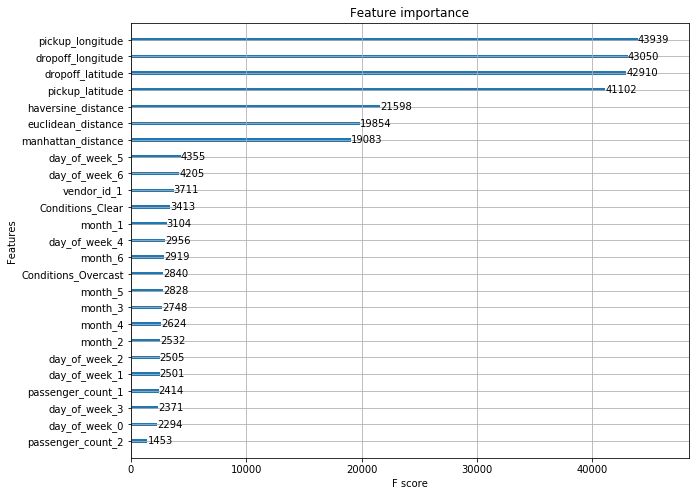

In [41]:
# Feature importance
fig, ax = plt.subplots(1, 1, figsize=(10,8))
xgb.plot_importance(reg, max_num_features=25, ax=ax)
plt.show()

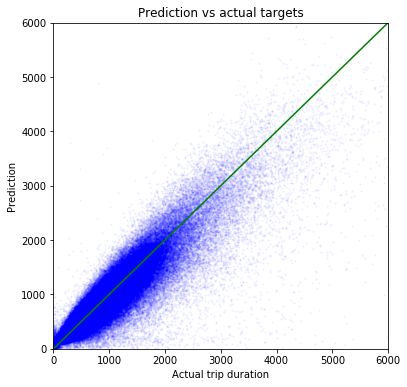

In [42]:
plt.figure(figsize=(6, 6))
plt.scatter(np.expm1(y_valid), np.expm1(pred_valid), s=2, color='blue', alpha=0.04)
plt.plot([1,6000],[1,6000], color='green')
plt.title('Prediction vs actual targets')
plt.xlabel('Actual trip duration')
plt.ylabel('Prediction')
ax = plt.gca()
ax.set_xlim([0, 6000])
ax.set_ylim([0, 6000])

plt.show()